In [4]:
### Preparing the Wrold Cup Workload
import sklearn as sl
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_file = 'https://raw.githubusercontent.com/nimamahmoudi/faas-keep-alive-modeling/master/datasets/wc98/invocation_count.csv'
df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
f = plt.figure(figsize=(10,12))
df['1998-07-1 08:00:01':'1998-07-03 08:00:00'].plot()
users = df['1998-07-01 08:00:01':'1998-07-03 08:00:00'].values

scaling = sl.preprocessing.MinMaxScaler()
scaled_users = np.ceil(120*scaling.fit_transform(users)).astype(int)
plt.plot(scaled_users)
plt.show(block = True)

HTTPError: HTTP Error 404: Not Found

In [48]:
### Preparing Kubernetes
import subprocess
import time
import sys
import time
import math
from kubernetes import client, config
import os


os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/ubuntu/jupyter/google.json"
dir_path = os.path.dirname(os.path.realpath('__file__'))


config.load_kube_config()
#%%
DEPLOYMENT_NAME = 'wordpress'
DEPLOYMENT_NS = 'default'


api_instance = client.ExtensionsV1beta1Api()

def get_replica_and_ready():
    api_response = api_instance.read_namespaced_deployment(DEPLOYMENT_NAME, DEPLOYMENT_NS)
    return api_response.status.replicas, api_response.status.ready_replicas

def set_replica_num(rnum):
    rnum = int(rnum)
    if rnum < 1:
        rnum = 1
    api_response = api_instance.read_namespaced_deployment(DEPLOYMENT_NAME, DEPLOYMENT_NS)
    api_response.spec.replicas = rnum
    api_instance.patch_namespaced_deployment_scale(DEPLOYMENT_NAME, DEPLOYMENT_NS, api_response)
    
print(get_replica_and_ready())
# Control Initial number of containers
u_pre = 1
set_replica_num(u_pre)





(1, 1)


In [49]:
# Controller Properties Initialization

r_setpoint = 800
heat = 0
def heat_model(lower_level,upper_level,response_time,prev_heat,heat_limit,u_pre):
    heat = prev_heat
    increase_number = 1
    decrease_number = 1
    if response_time > upper_level:
        if heat < 0 :
            heat = 0
        heat = heat+1 
    elif response_time < lower_level:
        if heat > 0:
            heat = 0
        heat = heat -1 
    else : 
        if heat > 0 : 
            heat = heat -1
        elif heat<0 : 
            heat = heat +1 
    if heat == heat_limit :
        u_pre = u_pre + increase_number
        heat = 0 
    elif heat == -heat_limit :
        u_pre = u_pre - decrease_number
        heat = 0 
    return heat , u_pre

In [ ]:
#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
try:
    os.chdir(os.path.join(os.getcwd(), 'examples'))
    print(os.getcwd())
except:
    pass
import ddsl_load_tester as load_tester


#%%
def custom_sensing():
    r1,r2 = get_replica_and_ready()
    return {'r1':r1 , 'r2':r2,'Heat':heat}
lt = load_tester.DdslLoadTester(hatch_rate=1, temp_stat_max_len=10, base='http://35.232.158.172:8089/')

lt.custom_sensing = custom_sensing
# Testing the function
lt.custom_sensing()
from tqdm.auto import tqdm
tqdm.pandas()

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

### You can change this user sequence to other workload ( Such as to World Cup workload )
user_sequence = scaled_users.flatten()+30

lt.custom_sensing = custom_sensing
lt.change_count(user_sequence[0])
lt.start_capturing()

loop_time_in_secs = load_tester.get_loop_time_in_secs('20s')

loop_timer.tic()
total_timer.tic()
results = None
for i in tqdm(range(len(user_sequence)*3)):
    user_count = user_sequence[math.floor(i/3)]
    lt.change_count(user_count)

    sleep_time = loop_time_in_secs - loop_timer.toc()
    if sleep_time > 0:
        time.sleep(sleep_time)

    loop_timer.tic()

    result = lt.get_all_stats()
    df_result = pd.DataFrame(data=result)

    if results is None:
        results = df_result
    else:
        results = results.append(df_result)



    ### Sometimes we get empty data and we dont want to do anything in that situation
    if (result['current_response_time_average'])!=[]:
        if result['current_response_time_average'][-1]!=None :
            heat ,u_pre = heat_model(lower_level=500,upper_level=800,response_time=np.nanmean(np.array(result['current_response_time_average'],dtype=float)),prev_heat=heat,heat_limit=5,u_pre=u_pre )
            current_responsetime = np.nanmean(np.array(result['current_response_time_average'],dtype=float))
            if u_pre <=1 :
                u_pre = 1
            elif u_pre >=40 :
                u_pre = 40
            try :
                set_replica_num(np.ceil(u_pre))
            except :
                print("exception occured")
            
            print("Number of Replica Request: ",result['custom_r1'][-1],"Number of Replica Ready: ",result['custom_r2'][-1],"control signal : ",u_pre,"error :", r_setpoint-current_responsetime," Heat : ",heat)

lt.stop_test()

results, filename = lt.prepare_results_from_df(results)

results.head()

Number of Replica Request:  1 Number of Replica Ready:  1 control signal :  1 error : 342.6666666666667  Heat :  -1
Number of Replica Request:  1 Number of Replica Ready:  1 control signal :  1 error : -1997.4  Heat :  1
Number of Replica Request:  1 Number of Replica Ready:  1 control signal :  1 error : -4988.2  Heat :  2
Number of Replica Request:  1 Number of Replica Ready:  1 control signal :  1 error : -8905.1  Heat :  3
Number of Replica Request:  1 Number of Replica Ready:  1 control signal :  1 error : -10980.6  Heat :  4
Number of Replica Request:  1 Number of Replica Ready:  1 control signal :  2 error : -13663.5  Heat :  0
Number of Replica Request:  2 Number of Replica Ready:  1 control signal :  2 error : -14087.5  Heat :  1
Number of Replica Request:  2 Number of Replica Ready:  1 control signal :  2 error : -13977.5  Heat :  2
Number of Replica Request:  2 Number of Replica Ready:  2 control signal :  2 error : -12353.0  Heat :  3
Number of Replica Request:  2 Number of

average res :  1318.221476510067 Var Res :  1615.1264473350195 average Container :  6.449664429530201 Var Container :  3.5387334055535153


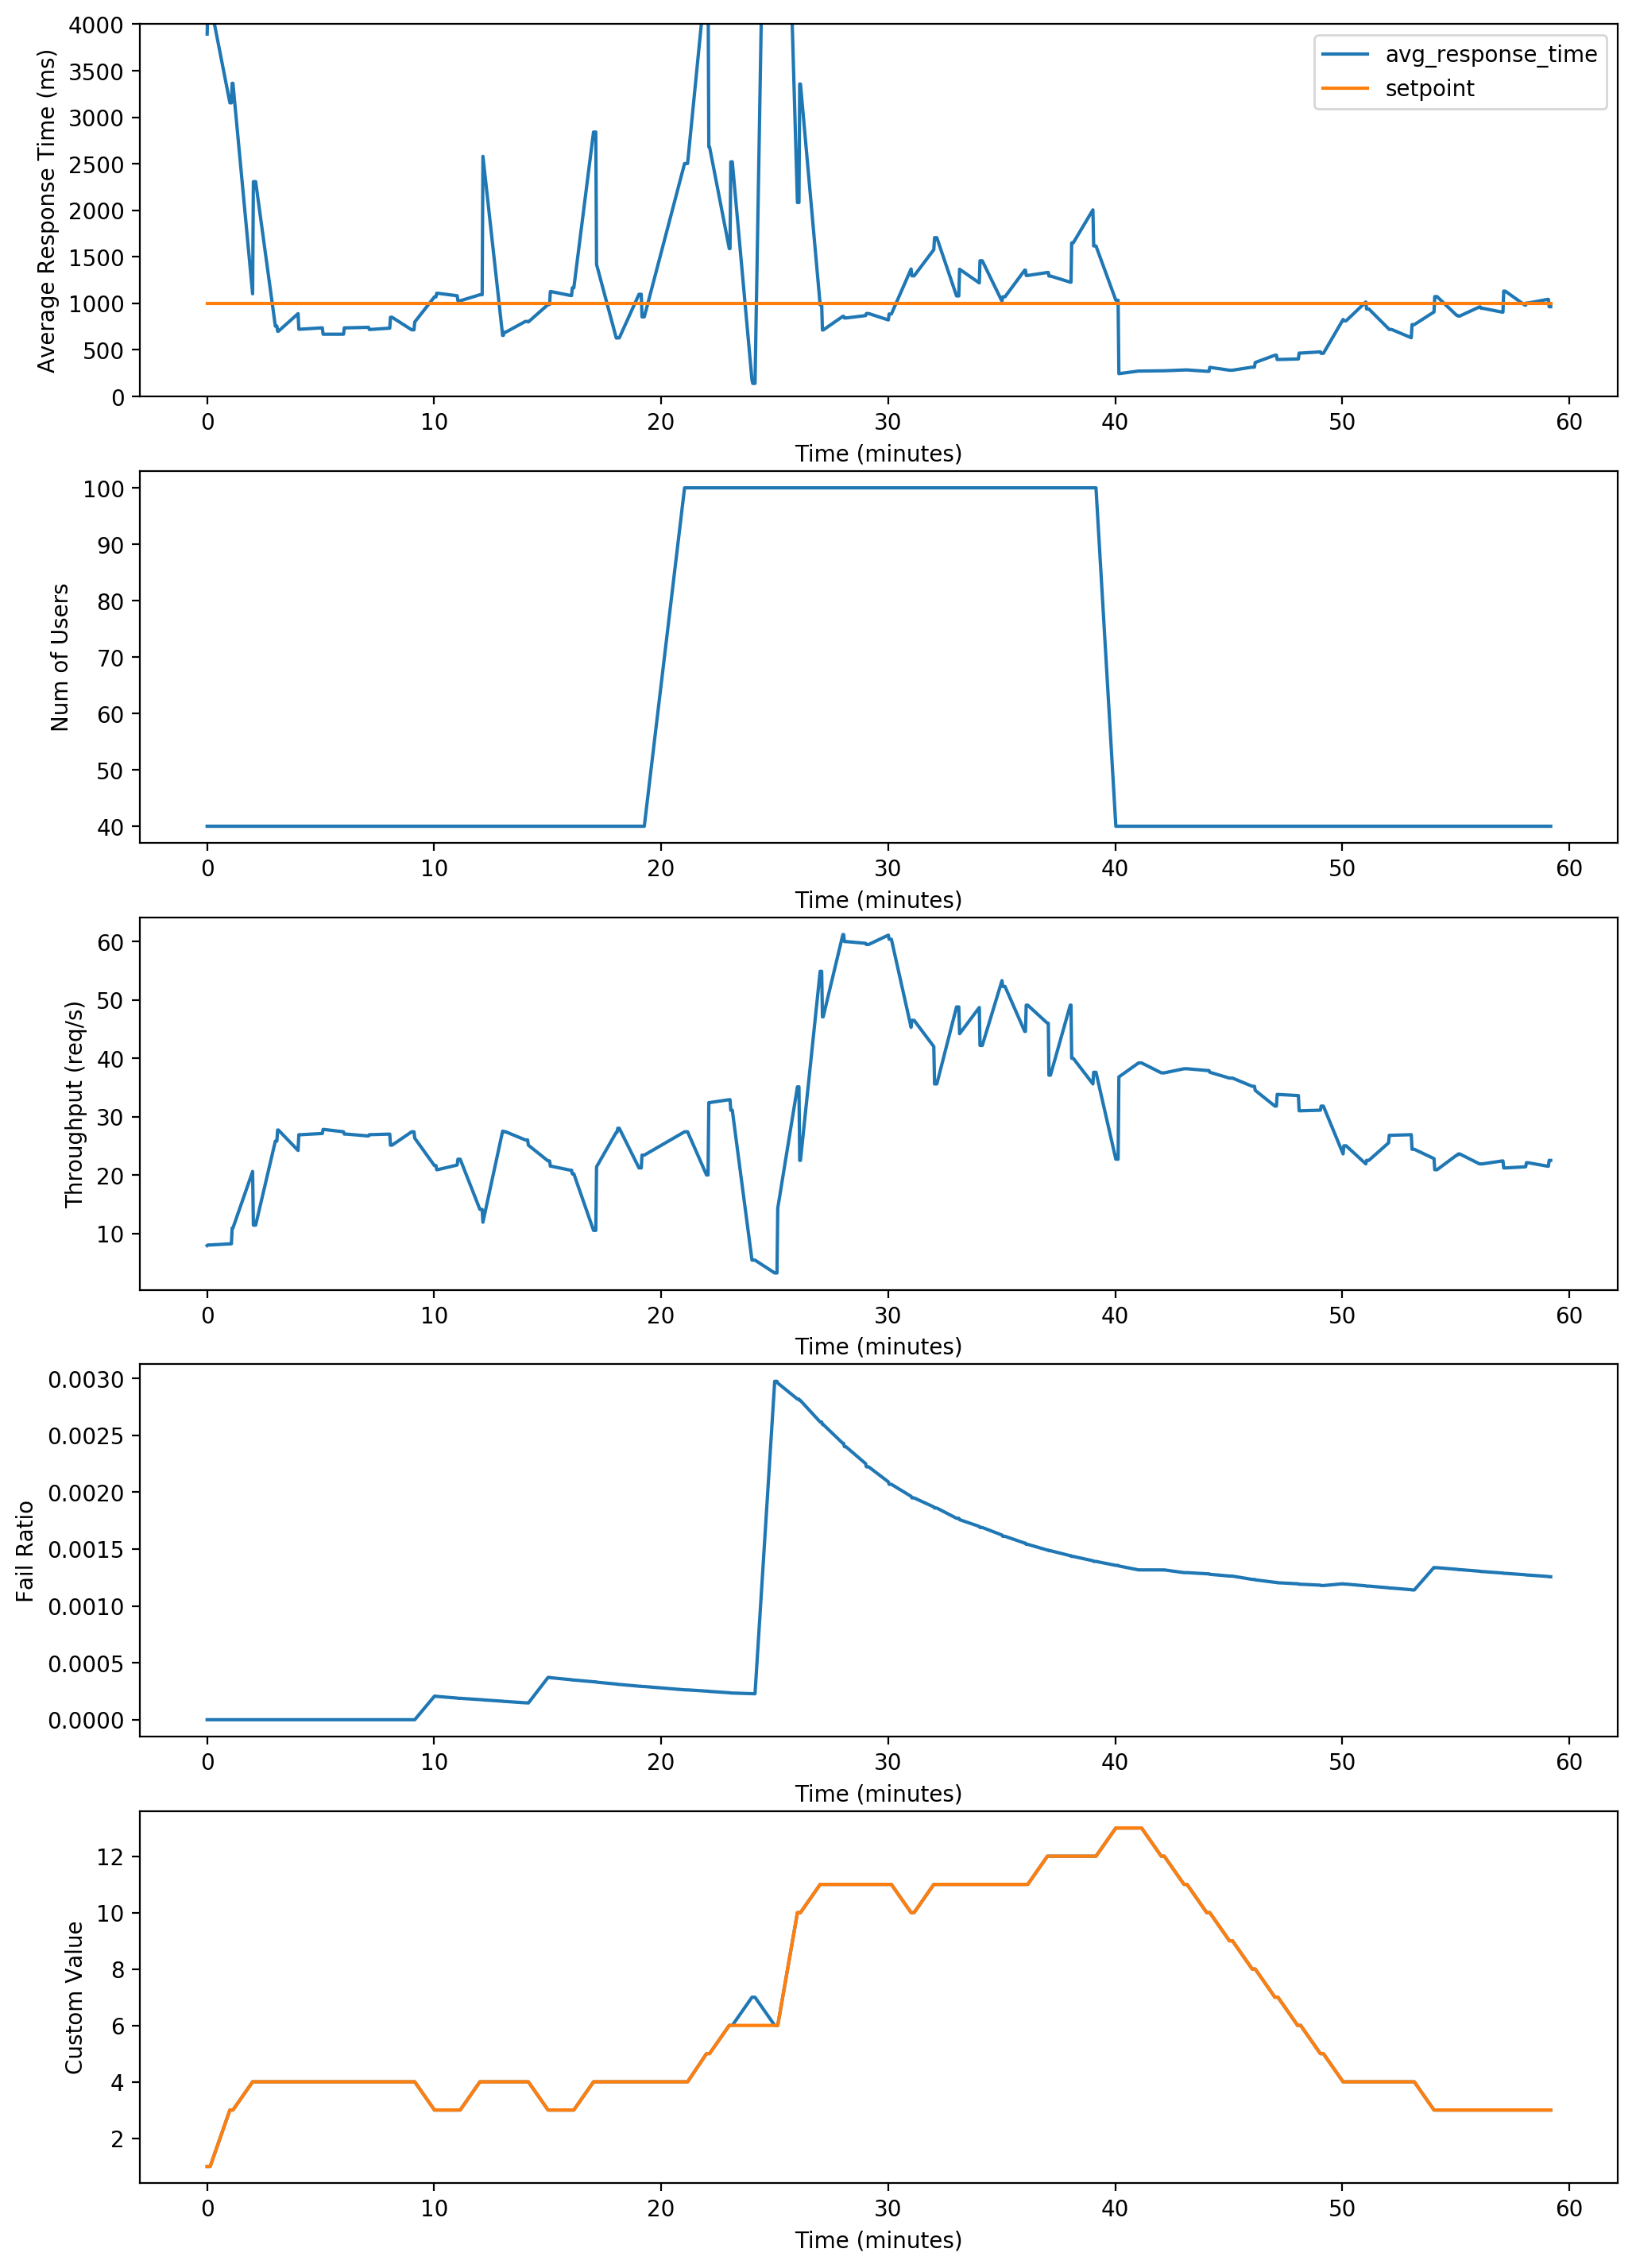

In [24]:
res = results
res = res[res['total_rps'] > 0]
responsetime_avg = np.nanmean(res['current_response_time_average'])
responsetime_var = np.sqrt(np.var(res['current_response_time_average']))
container_avg = np.average(res['custom_r2'])
container_var = np.sqrt(np.var(res['custom_r2']))
print("average res : ", responsetime_avg , "Var Res : ",responsetime_var, "average Container : ",container_avg, "Var Container : ", container_var )
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(12,18),dpi=200)
plt.subplot(511)
#plt.plot(res['elapsed_min'], res['min_response_time'], label='min_response_time')
#plt.plot(res['elapsed_min'], res['current_response_time_percentile_50'], label='median_response_time')
plt.plot(res['elapsed_min'], res['current_response_time_average'], label='avg_response_time')
plt.plot(res['elapsed_min'],r_setpoint*np.ones(len(res['current_response_time_average'])), label='setpoint')
#plt.plot(res['elapsed_min'], res['current_response_time_percentile_95'], label='95th percentile')
#plt.plot(res['elapsed_min'], res['max_response_time'], label='max_response_time')
plt.ylim((0,4000))
plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(512)
plt.plot(res['elapsed_min'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(513)
plt.plot(res['elapsed_min'], res['total_rps'])
plt.xlabel('Time (minutes)')
plt.ylabel('Throughput (req/s)')

plt.subplot(514)
plt.plot(res['elapsed_min'], res['fail_ratio'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Ratio')

plt.subplot(515)
plt.plot(res['elapsed_min'], res['custom_r1'])
plt.plot(res['elapsed_min'], res['custom_r2'])
plt.xlabel('Time (minutes)')
plt.ylabel('Custom Value')



filename = filename.replace('aa.csv', '')
plt.savefig(filename + '.png', dpi=300)
plt.savefig(filename + '.pdf')
plt.show()

lt.stop_test()

results, filename = lt.prepare_results_from_df(results)

results.head()
